In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(caret))
suppressMessages(library(MASS))
suppressMessages(library(car))
suppressMessages(library(dplyr))
suppressMessages(library(glmnet))
suppressMessages(library(Metrics))

Warning message:
"package 'tidyverse' was built under R version 4.3.2"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"
Warning message:
"package 'tibble' was built under R version 4.3.2"
Warning message:
"package 'tidyr' was built under R version 4.3.2"
Warning message:
"package 'readr' was built under R version 4.3.2"
Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
Warning message:
"package 'forcats' was built under R version 4.3.2"
Warning message:
"package 'lubridate' was built under R version 4.3.2"
Warning message:
"package 'caret' was built under R version 4.3.3"
Warning message:
"package 'MASS' was built under R version 4.3.3"
Warning message:
"package 'car' was built under R version 4.3.3"
Warning message:
"package 'carData' was built under R version 4.3.3"
Warning message:
"package 'glmnet' was built under R version 4.3.3"
Warning message:
"package 'Matrix' was built un

In [2]:
shooting <- read.csv('Shooting_filtered.csv')
shooting <- na.omit(shooting)
shooting <- filter(shooting, Gls != 0)

In [3]:
glimpse(shooting)

Rows: 586
Columns: 25
$ Player  <chr> "Salis Abdul Samed", "Tammy Abraham", "Che Adams", "Yacine Adl…
$ Nation  <chr> "gh GHA", "eng ENG", "sct SCO", "fr FRA", "fr FRA", "es ESP", …
$ Pos     <chr> "MF", "FW", "FW", "MFFW", "FW", "MF", "MF", "MF", "FW", "FW", …
$ Squad   <chr> "Clermont Foot", "Roma", "Southampton", "Bordeaux", "Strasbour…
$ Comp    <chr> "fr Ligue 1", "it Serie A", "eng Premier League", "fr Ligue 1"…
$ Age     <int> 21, 23, 25, 21, 27, 28, 30, 23, 17, 26, 27, 28, 30, 26, 31, 23…
$ Born    <int> 2000, 1997, 1996, 2000, 1994, 1992, 1991, 1998, 2004, 1995, 19…
$ X90s    <dbl> 27.4, 34.3, 22.7, 25.1, 30.4, 26.1, 17.0, 25.8, 20.4, 16.5, 19…
$ Gls     <dbl> 0.04, 0.50, 0.31, 0.04, 0.39, 0.19, 0.06, 0.04, 0.20, 0.06, 0.…
$ Sh      <dbl> 0.66, 2.68, 2.16, 1.27, 1.84, 1.80, 1.47, 1.78, 2.06, 2.61, 1.…
$ SoT     <dbl> 0.18, 1.02, 1.06, 0.60, 0.79, 0.61, 0.35, 0.54, 0.74, 0.91, 0.…
$ SoT.    <dbl> 27.8, 38.0, 49.0, 46.9, 42.9, 34.0, 24.0, 30.4, 35.7, 34.9, 21…
$ Sh.90   <dbl> 0.

In [4]:
shooting <- filter(shooting, Sh >= 1)
shooting <- dplyr::select(shooting, -Sh.90, -SoT.90)

12 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept)  0.0547338434
Age          0.0003387673
X90s         0.0004136614
Sh          -0.0343165279
SoT          0.4316022943
SoT.        -0.0089989538
G.Sh         2.2451651201
G.SoT       -0.1095972627
Dist         0.0009613583
FK          -0.0468366524
PK           0.8932781945
PKatt        0.1227595618


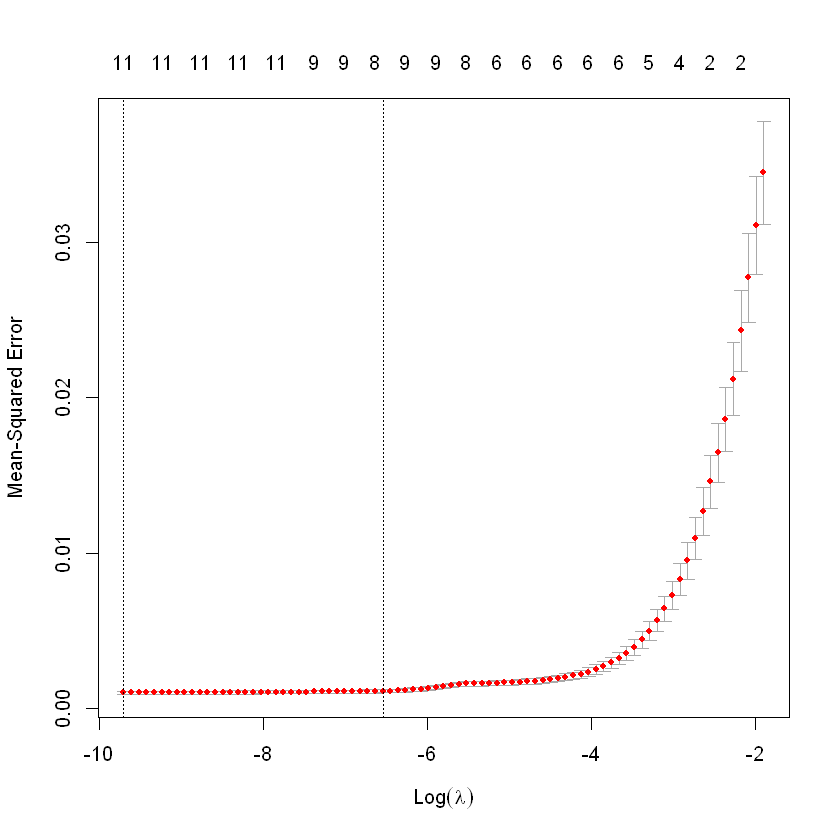

In [5]:
predictors <- shooting %>%
  dplyr::select_if(is.numeric) %>%
  dplyr::select(-Gls, -xG, -npxG, -G.xG, -np.G.xG, -npxG.Sh, -Born) %>%
  as.matrix()

response <- shooting$Gls

set.seed(1) # for reproducibility
cv.lasso <- cv.glmnet(predictors, response, alpha = 1)

lasso.model <- glmnet(predictors, response, alpha = 1, lambda = cv.lasso$lambda.min)

print(coef(lasso.model))

plot(cv.lasso)

In [6]:
# Prepare the data
set.seed(123) # for reproducibility
selected_features <- colnames(predictors)
index <- createDataPartition(shooting$Gls, p = 0.8, list = FALSE)
train_data <- shooting[index, ]
test_data <- shooting[-index, ]

# Fit the model
model <- lm(Gls ~ ., data = train_data[, c(selected_features, 'Gls')])
# Predict on the test set
predictions <- predict(model, newdata = test_data, type = "response")

# Evaluate the model
mse <- mean((test_data$Gls - predictions)^2)
r_squared <- 1 - sum((test_data$Gls - predictions)^2) / sum((test_data$Gls - mean(test_data$Gls))^2)

print(paste("MSE:", mse))
print(paste("R-squared:", r_squared))


[1] "MSE: 0.000940239928132191"
[1] "R-squared: 0.963705815036682"


In [7]:
predictors <- as.data.frame(predictors)

head(dplyr::select(shooting, Age, Born, X90s, Sh, SoT, SoT., G.Sh, G.SoT, Dist, FK, PK, PKatt))

,Age,Born,X90s,Sh,SoT,SoT.,G.Sh,G.SoT,Dist,FK,PK,PKatt
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23,1997,34.3,2.68,1.02,38.0,0.15,0.40,12.9,0.09,0.09,0.09
2,25,1996,22.7,2.16,1.06,49.0,0.14,0.29,13.3,0.00,0.00,0.00
3,21,2000,25.1,1.27,0.60,46.9,0.03,0.07,21.2,0.16,0.00,0.00
4,27,1994,30.4,1.84,0.79,42.9,0.16,0.38,13.5,0.00,0.10,0.10
5,28,1992,26.1,1.80,0.61,34.0,0.11,0.31,21.0,0.08,0.00,0.00
6,30,1991,17.0,1.47,0.35,24.0,0.04,0.17,19.3,0.00,0.00,0.00


In [18]:
round(1 / shooting$Gls, 0)

[1]  2  3 25  3  5 17 25  5 17 20  5  5  3  5  3  8  8  2  8 20  6  2 14  2  3
 [26]  2  8 20  4 25 11  2  6 11  4 20  4  8  3  3  5  4 12 10  2  1  3  1  2  8
 [51] 17 20  2  3 10  6  2  3  3  8  3  4  3  3  3  3  4  4  2  5  3  4  6  5  3
 [76]  3  5 10 25  5  6  2 33  2  2  6 14  7  5  8  9  2 11 10  2  2  8  8  6  2
[101]  1 17 25 11  3  2  2  3  4  2  2  7 10  4  3  8 14  9  3  2  2  3 20  2  6
[126]  2  6  3  8  3  5  3  3  5  5  3  8  8  5  6  7  4  2  6  5  3 25 12  6  3
[151]  2  2  6  4  4  4  6  5  3  5  7  2  6  3 11  2  3  9  3  6  1  5 10  4  2
[176]  4 14 11  3  1 14  2  4  4  3  3  2  1  3  2  4 11  4 20  7  6  6  4  3  5
[201]  6  7  2  2  2  1  3  2  6  6  2  6  2 17 14 20  4  2  4  5 25  5  5  3 12
[226]  6 33  8  5 25 17 20  2  5  2  5  3 12  3 25  4  1  4  4  7  3 17 12  8  3
[251]  4 17  2  2  5  4  2 17  2  3 25  4  3  4  2  6  3  3  1  5 25  3  3  1  8
[276]  8 11  5 33 25  3  2  8 17 11  1  4  3  2  3  2  4  2  6  1 11  4  2  5 17
[301]  8  3  6  3  2 10  4  4  8  2  3 17  3  3  6  7  2  6  8  2  2  8  5 20  5
[326]  4  3  4  7  5  3  2  5  9  2 12 12  4  3 11  2  3  2  8  2  3  3  7 17  2
[351]  3  2  6  8 14  6  3 17  8 25  4  3  6  4  3  5  6  5  5  3  2 25  3 20  3
[376]  3  4 33 10  5  4  4 10  8  4  2  4  2 20  6  3  1  4  8  6  3  3  9 17  7
[401]  3 14  9  4  3  1  1  5 25  8  3 11  2  4 10  2  4 12  5  2  5  2  5  7 20
[426]  2  5  2  9  3  5  5 11  1  3  5  5 25  2  2  6  3  5  4 33 11  4  5 20  4
[451]  4  3  2  2  5  1 20  3  6  1  3 33  4 17  3  6  8  3  3 20  4 11  2  8  3
[476]  4  5  6 25  6 17  5  2  8 11  2  4  4  4  5

In [24]:
shooting$Gls

[1] 0.50 0.31 0.04 0.39 0.19 0.06 0.04 0.20 0.06 0.05 0.19 0.20 0.30 0.22 0.30
 [16] 0.13 0.12 0.47 0.12 0.05 0.17 0.52 0.07 0.52 0.29 0.62 0.13 0.05 0.26 0.04
 [31] 0.09 0.42 0.16 0.09 0.26 0.05 0.25 0.12 0.33 0.30 0.21 0.27 0.08 0.10 0.53
 [46] 0.89 0.33 0.94 0.48 0.12 0.06 0.05 0.46 0.30 0.10 0.16 0.48 0.30 0.33 0.12
 [61] 0.31 0.24 0.31 0.36 0.37 0.39 0.28 0.27 0.41 0.19 0.38 0.25 0.16 0.20 0.39
 [76] 0.35 0.21 0.10 0.04 0.20 0.17 0.40 0.03 0.46 0.58 0.18 0.07 0.14 0.19 0.12
 [91] 0.11 0.61 0.09 0.10 0.48 0.61 0.13 0.13 0.17 0.59 0.86 0.06 0.04 0.09 0.35
[106] 0.46 0.45 0.33 0.27 0.42 0.64 0.15 0.10 0.28 0.36 0.13 0.07 0.11 0.34 0.44
[121] 0.47 0.34 0.05 0.57 0.17 0.51 0.18 0.37 0.12 0.35 0.19 0.29 0.38 0.21 0.19
[136] 0.32 0.12 0.13 0.20 0.16 0.15 0.25 0.42 0.16 0.21 0.30 0.04 0.08 0.18 0.32
[151] 0.52 0.58 0.18 0.23 0.25 0.27 0.16 0.19 0.33 0.19 0.14 0.58 0.16 0.29 0.09
[166] 0.42 0.38 0.11 0.39 0.18 1.04 0.21 0.10 0.27 0.40 0.25 0.07 0.09 0.38 0.69
[181] 0.07 0.52 0.24 0.25 0.34 0.29 0.57 0.90 0.33 0.43 0.25 0.09 0.25 0.05 0.15
[196] 0.16 0.17 0.25 0.38 0.21 0.16 0.14 0.45 0.40 0.57 0.68 0.36 0.57 0.16 0.16
[211] 0.50 0.17 0.47 0.06 0.07 0.05 0.23 0.40 0.24 0.20 0.04 0.19 0.19 0.37 0.08
[226] 0.17 0.03 0.12 0.20 0.04 0.06 0.05 0.40 0.20 0.52 0.22 0.31 0.08 0.38 0.04
[241] 0.25 1.07 0.23 0.23 0.14 0.37 0.06 0.08 0.13 0.38 0.28 0.06 0.43 0.45 0.21
[256] 0.26 0.44 0.06 0.66 0.29 0.04 0.27 0.34 0.26 0.51 0.17 0.30 0.29 0.83 0.19
[271] 0.04 0.32 0.31 0.83 0.12 0.13 0.09 0.20 0.03 0.04 0.37 0.58 0.12 0.06 0.09
[286] 0.71 0.25 0.31 0.45 0.32 0.44 0.27 0.50 0.18 0.69 0.09 0.27 0.46 0.21 0.06
[301] 0.12 0.35 0.17 0.35 0.42 0.10 0.28 0.24 0.13 0.53 0.31 0.06 0.31 0.29 0.17
[316] 0.14 0.63 0.17 0.13 0.66 0.44 0.13 0.19 0.05 0.19 0.25 0.31 0.28 0.15 0.19
[331] 0.30 0.64 0.21 0.11 0.48 0.08 0.08 0.24 0.30 0.09 0.59 0.30 0.42 0.13 0.40
[346] 0.35 0.35 0.15 0.06 0.41 0.32 0.43 0.16 0.12 0.07 0.16 0.38 0.06 0.12 0.04
[361] 0.23 0.30 0.16 0.24 0.30 0.22 0.17 0.19 0.22 0.34 0.41 0.04 0.33 0.05 0.32
[376] 0.36 0.26 0.03 0.10 0.22 0.24 0.23 0.10 0.13 0.24 0.66 0.26 0.45 0.05 0.16
[391] 0.33 0.75 0.23 0.13 0.16 0.30 0.38 0.11 0.06 0.14 0.32 0.07 0.11 0.24 0.30
[406] 0.67 1.04 0.19 0.04 0.12 0.30 0.09 0.48 0.25 0.10 0.58 0.23 0.08 0.20 0.47
[421] 0.19 0.40 0.22 0.15 0.05 0.55 0.22 0.54 0.11 0.35 0.20 0.21 0.09 0.68 0.30
[436] 0.19 0.21 0.04 0.47 0.52 0.17 0.37 0.20 0.25 0.03 0.09 0.25 0.19 0.05 0.25
[451] 0.26 0.39 0.51 0.41 0.22 0.75 0.05 0.37 0.16 0.83 0.33 0.03 0.28 0.06 0.34
[466] 0.17 0.12 0.35 0.37 0.05 0.26 0.09 0.52 0.13 0.34 0.25 0.20 0.17 0.04 0.16
[481] 0.06 0.19 0.46 0.13 0.09 0.52 0.26 0.23 0.23 0.21

In [8]:
nozero <- shooting

In [19]:
# unnormalized <- round(nozero$Gls * nozero$X90s, 0)
unnormalized <- round(1 / shooting$Gls, 0)

In [20]:
mean(unnormalized)

[1] 6.746939

In [21]:
var(unnormalized)

[1] 40.6025

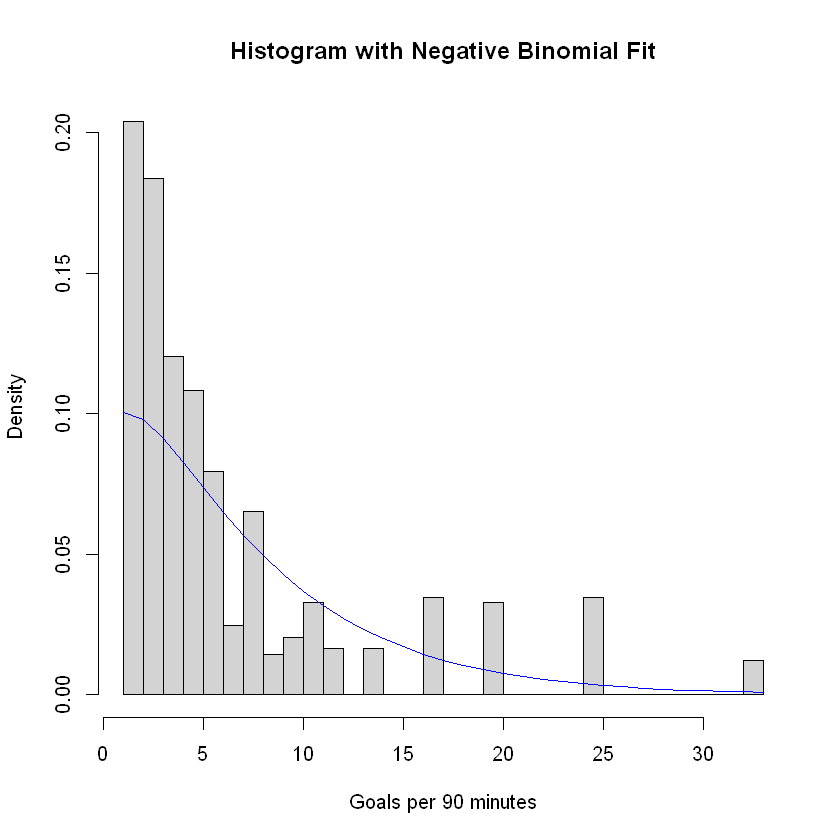

In [22]:
# Assuming 'nozero' is your data frame with non-zero goals per 90 minutes
# Let's say 'Gls' is your goals column

# Calculate mean and variance
mean_gls <- mean(unnormalized)
var_gls <- var(unnormalized)

# Estimate size and prob parameters for the Negative Binomial distribution
size <- (mean_gls^2) / (var_gls - mean_gls)
prob <- mean_gls / var_gls

# Create a sequence of goal values
goal_vals <- seq(min(unnormalized), max(unnormalized), by = 1)

# Calculate expected frequencies
expected_freqs <- dnbinom(goal_vals, size = size, prob = prob)

# Create histogram of the data
hist(unnormalized, breaks = 30, probability = TRUE,
     main = "Histogram with Negative Binomial Fit",
     xlab = "Goals per 90 minutes", ylab = "Density")

# Overlay the expected Negative Binomial frequencies
lines(goal_vals, expected_freqs, col = "blue")
